# Using Monte Carlo to Compute Error Bands On Our Boost Factor

# 1: Imports

In [23]:
# local scripts
import optimization as opt # all functions to optimize the stack
import boost

# numerical computing
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import fminbound

#stats
import scipy.stats as stats

# utilities
from time import time
from time import sleep
from copy import deepcopy
from IPython.display import clear_output
import scipy.constants as const


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm


SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26
LINEWIDTH = 4
MARKERSIZE = 5
FIGSIZE = (9.652,9.652)
palette = sns.color_palette("colorblind")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=LINEWIDTH)  # thickness of lines
plt.rc('lines', markersize=MARKERSIZE)  # size of the marker

# 2: Setting some parameters

In [24]:
# importing the thickness list
N1,N2 = 1.4656, 2.0218 
wave_target=805e-9
thick=wave_target/(2*N1)##m
chirp=0
nLayers=48

measurementErr = 5*1e-9 #m
thicklistMeasured = np.loadtxt("measured-thickness-080821.txt",skiprows=1)[:,0] * 1e-9 # nm -->m

# we start with just adding +- 5 to the thickness list
thicklistWitherr = (thicklistMeasured+measurementErr,thicklistMeasured-measurementErr)




# 3: Define a function for introducing random error to given layer thicknesses

In [25]:
def normalize(data,kind="01"):
    '''
    normalized such that min(data)-->0 and max(data)-->1 if 01, else min(data)-->0 and max(data)-->-1 if 10
    '''
    data = np.array(data)
    if (kind=="01"):
        normalized = (data-min(data))/(max(data)-min(data))
    else:
        normalized = (min(data)-data)/(max(data)-min(data))
    return normalized

# 4: Download the thicknesses and their error from the measured stack and plot its boost factors

In [26]:
waveMeas,solMeas =  boost.solution_rightwave(N1,N2,thick,nLayers,isTList=thicklistMeasured,mirror=True)
print(len(thicklistMeasured))
mass= const.h*const.c/(waveMeas*1e-9)*6.2*1e18


/Users/Lallina/Dropbox/2.NYUAD/1.DarkPhotons/haloscope/Analysis/boost-error-optimization/boost.py:21: RuntimeWarning: overflow encountered in double_scalars
  factor=0.5*((1/(n2**2))-(1/(n1**2)))


46


In [27]:
w,boost_factor=boost.solution_rightwave(N1,N2,thick,nLayers,isTList=thicklistMeasured,mirror=True)

m= const.h*const.c/(waveMeas*1e-9)*6.2*1e18


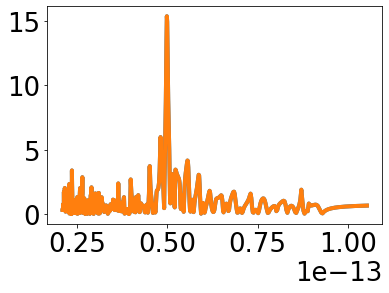

In [28]:
plt.plot(mass,solMeas)
plt.plot(m,boost_factor);

In [29]:
measlist = deepcopy(thicklistMeasured)
errlist = np.loadtxt("measured-thickness-080821.txt",skiprows=1)[:,1] * 1e-9 # nm -->m # get err b/w 1e-9 and 5e-9

# 5: Make a list of 10000 Stacks, each of which has its layers gaussianly modified from their measured values
This takes about 3 hours

In [30]:
errfunc = lambda mu,sigma: np.abs(np.random.normal(mu,sigma))

# simulate new lists of thicknesses by gaussian variations
nsims = 10000
thicksims  = np.zeros(shape=(nsims,len(measlist)))

for ridx in range(0,nsims):
    for cidx,d in enumerate(measlist):
        thicksims[ridx][cidx] = errfunc(measlist[cidx],errlist[cidx])

In [ ]:
import tqdm
energydistlist = [] #each row corresponds to the boost for each thickness simulation

# create a boost spectrum for each of these simulated thicknesses
t1 = time()
for thicklists in tqdm.tqdm(thicksims):
    energydistlist.append(boost.solution_rightwave(N1,N2,thick,48,isTList=list(thicklists),mirror=True))
t2 = time()
telapsed = t2-t1
print(f"Execution took {telapsed/60:2.2f} minutes")

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/Lallina/Dropbox/2.NYUAD/1.DarkPhotons/haloscope/Analysis/boost-error-optimization/boost.py:21: RuntimeWarning: overflow encountered in double_scalars
  factor=0.5*((1/(n2**2))-(1/(n1**2)))
 43%|████▎     | 4299/10000 [24:21:42<6:04:22,  3.83s/it]       

# 6: At Each Mass/Energy/Wavelength, find the 85th percentile, the 15th percentile and the 50th percentile of the boost factors from the 10000 Stacks

In [ ]:
#np.save("10000sim-energydist.npy",energydistlist)
percentilelist85 = np.percentile(energydistlist,85,axis=0)
percentilelist50 = np.percentile(energydistlist,50,axis=0)
percentilelist15 = np.percentile(energydistlist,15,axis=0)


# 7: Plot Wavelength/Mass Against Boost Factor

NameError: name 'percentilemass' is not defined

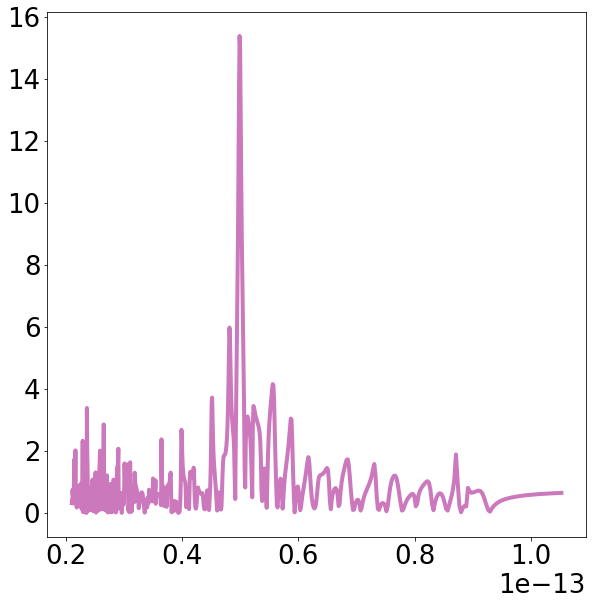

In [22]:
fig = plt.figure(figsize=FIGSIZE)
ax1 = fig.add_subplot(111)

mass= const.h*const.c/(waveMeas*1e-9)*6.2*1e18


ax1.plot(mass,solMeas, label='measured',color=palette[4])
ax1.fill_between(percentilemass,y1=percentilelist15[1],y2=percentilelist85[1],color=palette[-3],alpha=0.3,label='15th to 85th percentile')

ax1.set_xlabel("$m_x$ [eV/c$^2$]")
ax1.set_ylabel(r'$\beta$')
ax1.set_xlim(xmin=1,xmax=2.6)
ax1.set_xlim(xmin=1,xmax=2.6)

ax1.legend(loc='upper right',fontsize=19)


transform = lambda m: const.h*const.c/(m*1e-9)*6.2*1e18



secax = ax1.secondary_xaxis('top',functions=(transform,transform))
secax.set_xlabel('$\lambda$ [nm]',labelpad=10)
secax.set_xscale("linear")




#plt.savefig("boostspectrumbands.svg",dpi=300)
#plt.grid()
plt.show()

# 8: Save the 15th and 85th percentile boost factors

In [ ]:
np.save("boost-err-85per.npy",[percentilewave,percentilelist85[1]])
np.save("boost-err-15per.npy",[percentilewave,percentilelist15[1]])
np.save("boost-err-50per.npy",[percentilewave,percentilelist50[1]])